In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
IMG_HEIGHT = 448
IMG_WIDTH = 448
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

seed = 42

In [ ]:
train_frame_path = '/content/drive/MyDrive/LeafSeg/train_frames/'
train_mask_path = '/content/drive/MyDrive/LeafSeg/train_masks/'

val_frame_path = '/content/drive/MyDrive/LeafSeg/val_frames/'
val_mask_path = '/content/drive/MyDrive/LeafSeg/val_masks/'

In [ ]:
train_frame_ids = os.listdir(train_frame_path)
train_mask_ids = os.listdir(train_mask_path)

train_frame_ids=sorted(train_frame_ids)
train_mask_ids=sorted(train_mask_ids)  

X_train = np.zeros((len(train_frame_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_train = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_frame_ids), total=len(train_frame_ids)):
    path = train_frame_path + id_
    img = ((imread(path))/255)[:,:,:IMG_CHANNELS]
    sizes_train.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

print('Done!')
print(train_frame_ids)

Y_train = np.zeros((len(train_mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
sizes_trainmasks = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_mask_ids), total=len(train_mask_ids)):
    path = train_mask_path + id_
    img = (imread(path))/255
    sizes_trainmasks.append([img.shape[0], img.shape[1]])
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),axis=-1)
    Y_train[n] = img

print('Done!')
print(train_mask_ids)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

img=X_train[50,:,:,:]
imshow(img)
plt.show()
X_train.shape

In [ ]:
val_frame_ids = os.listdir(val_frame_path)
val_mask_ids = os.listdir(val_mask_path)

val_frame_ids=sorted(val_frame_ids)
val_mask_ids=sorted(val_mask_ids)  

X_val = np.zeros((len(val_frame_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_val = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_frame_ids), total=len(val_frame_ids)):
    path = val_frame_path + id_
    img = ((imread(path))/255)[:,:,:IMG_CHANNELS]
    sizes_val.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_val[n] = img

print('Done!')
print(val_frame_ids)

Y_val = np.zeros((len(val_mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
sizes_valmasks = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(val_mask_ids), total=len(val_mask_ids)):
    path = val_mask_path + id_
    img = (imread(path))/255
    sizes_valmasks.append([img.shape[0], img.shape[1]])
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),axis=-1)
    Y_val[n] = img

print('Done!')
print(val_mask_ids)

In [ ]:
test_frame_path = '/content/drive/My Drive/LeafSeg/test_frames/'
test_mask_path = '/content/drive/My Drive/LeafSeg/test_masks/'


test_frame_ids = os.listdir(test_frame_path)
test_mask_ids = os.listdir(test_mask_path)

test_frame_ids=sorted(test_frame_ids)
test_mask_ids=sorted(test_mask_ids)  

X_test = np.zeros((len(test_frame_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_frame_ids), total=len(test_frame_ids)):
    path = test_frame_path + id_
    img = ((imread(path))/255)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')
print(test_frame_ids)

Y_test = np.zeros((len(test_mask_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
sizes_testmasks = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_mask_ids), total=len(test_mask_ids)):
    path = test_mask_path + id_
    img = (imread(path))/255
    sizes_testmasks.append([img.shape[0], img.shape[1]])
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),axis=-1)
    Y_test[n] = img

print('Done!')
print(test_mask_ids)

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
from keras.preprocessing import image
BATCH_SIZE = 8 # the higher the better
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', horizontal_flip=True, vertical_flip = True)
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', horizontal_flip=True, vertical_flip = True)

# Keep the same seed for image and mask generators so they fit together

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)



# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_val[int(X_val.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_val[int(Y_val.shape[0]*0.9):], augment=True, seed=seed)


x_val=image_datagen_val.flow(X_val[int(X_val.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_val[int(Y_val.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0])
plt.show()
imshow(np.squeeze(y.next()[0]))
plt.show()



In [ ]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [ ]:
from keras.models import *
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, concatenate


def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path


def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=16, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [64, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 512], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):

    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 512], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [64, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [16, 32], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 1024], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return Model(inputs, path)

In [ ]:
input_shape=(416,416,3)

In [ ]:
from keras.utils.vis_utils import plot_model
model=build_res_unet(input_shape)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras import backend as K

def mcor(y_true, y_pred):
  #matthews_correlation
  y_pred_pos = K.round(K.clip(y_pred, 0, 1))
  y_pred_neg = 1 - y_pred_pos
 
 
  y_pos = K.round(K.clip(y_true, 0, 1))
  y_neg = 1 - y_pos
 
 
  tp = K.sum(y_pos * y_pred_pos)
  tn = K.sum(y_neg * y_pred_neg)
 
 
  fp = K.sum(y_neg * y_pred_pos)
  fn = K.sum(y_pos * y_pred_neg)
 
 
  numerator = (tp * tn - fp * fn)
  denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
  return numerator / (denominator + K.epsilon())

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def iou(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
    
def precision(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def recall(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall


def f1(y_true, y_pred):
  def recall(y_true, y_pred):        
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):        
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.metrics import *

NO_OF_TRAINING_IMAGES = len(os.listdir('/content/drive/My Drive/LeafSeg/train_frames/'))
NO_OF_VAL_IMAGES = len(os.listdir('/content/drive/My Drive/LeafSeg/val_frames/'))

NO_OF_EPOCHS = 80

BATCH_SIZE = 8

weights_path = '/content/drive/My Drive/LeafSeg/cp.ckpt'

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss=dice_coef_loss,
              optimizer=opt,
              metrics=[dice_coef,iou, precision, recall, f1,specificity,negative_predictive_value,mean_absolute_error,'accuracy'])

checkpoint = ModelCheckpoint(filepath=weights_path, monitor=dice_coef, 
                             verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger('./log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = dice_coef, verbose = 1,
                              min_delta = 0.05, patience = 3, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]

results = model.fit_generator(train_generator, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_generator, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks=callbacks_list)

model.save('/content/drive/My Drive/LeafSeg/Res_unet.h5') 

In [ ]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # - Works
import tensorflow as tf
from tensorflow.keras.metrics import *

opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss=dice_coef_loss,
              optimizer=opt,
              metrics=[dice_coef,iou, precision, recall, f1,specificity,negative_predictive_value,mean_absolute_error,'accuracy'])
model.load_weights('/content/drive/MyDrive/LeafSeg/Res_unet.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/LeafSeg/Res_unet.h5')
model.evaluate(X_test,Y_test,8)

In [ ]:
NO_OF_TEST_IMAGES = len(os.listdir('/content/drive/My Drive/LeafSeg/test_frames/'))
test_preds1 = model.predict(X_test, 8)
print(test_preds1.shape)

In [ ]:
pred = (test_preds1 >= 0.5).astype(np.uint8)
test_img1 = pred[15, :, :,0]
plt.imshow(test_img1,cmap='gray')
print('Shape: ', test_img1.shape)
print('Max pixel value: ', test_img1.max())
print('Min pixel value: ', test_img1.min())

(-0.5, 447.5, 447.5, -0.5)

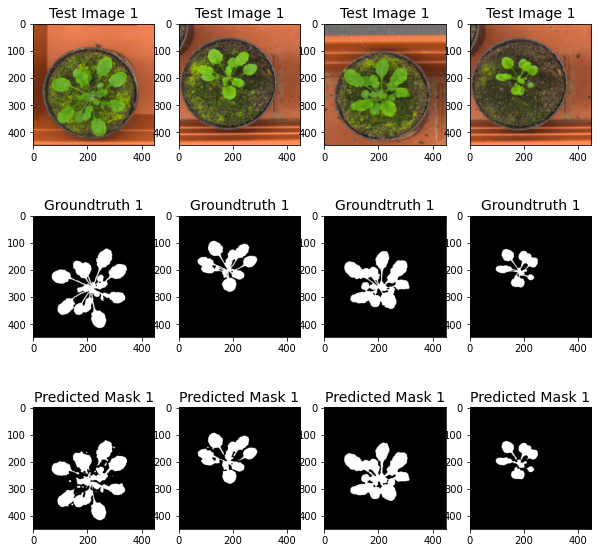

In [ ]:

# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,4,1)
img1=X_test[106,:,:,:]
plt.imshow(img1)
plt.title('Test Image 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,5)
mask1=Y_test[106,:,:,0]
plt.imshow(mask1,cmap='gray')
plt.title('Groundtruth 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,9)
preds_test_thresh1 = (test_preds1 >= 0.5).astype(np.uint8)
test_mask1 = preds_test_thresh1[106, :, :,0]
plt.imshow(test_mask1,cmap='gray')
plt.title('Predicted Mask 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,2)
img1=X_test[18,:,:,:]
plt.imshow(img1)
plt.title('Test Image 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,6)
mask1=Y_test[18,:,:,0]
plt.imshow(mask1,cmap='gray')
plt.title('Groundtruth 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,10)
preds_test_thresh1 = (test_preds1 >= 0.5).astype(np.uint8)
test_mask1 = preds_test_thresh1[18, :, :,0]
plt.imshow(test_mask1,cmap='gray')
plt.title('Predicted Mask 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,3)
img1=X_test[22,:,:,:]
plt.imshow(img1)
plt.title('Test Image 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,7)
mask1=Y_test[22,:,:,0]
plt.imshow(mask1,cmap='gray')
plt.title('Groundtruth 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,11)
preds_test_thresh1 = (test_preds1 >= 0.5).astype(np.uint8)
test_mask1 = preds_test_thresh1[22, :, :,0]
plt.imshow(test_mask1,cmap='gray')
plt.title('Predicted Mask 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,4)
img1=X_test[4,:,:,:]
plt.imshow(img1)
plt.title('Test Image 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,8)
mask1=Y_test[4,:,:,0]
plt.imshow(mask1,cmap='gray')
plt.title('Groundtruth 1', fontsize=14)
plt.axis('on')

plt.subplot(3,4,12)
preds_test_thresh1 = (test_preds1 >= 0.5).astype(np.uint8)
test_mask1 = preds_test_thresh1[4, :, :,0]
plt.imshow(test_mask1,cmap='gray')
plt.title('Predicted Mask 1', fontsize=14)
plt.axis('on')

In [ ]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, coef, label='Training Dice Coefficient')
plt.plot(epochs_range, val_coef, label='Validation Dice Coefficient')
plt.legend(loc='lower right')
plt.title('Training and Validation Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()